<a href="https://colab.research.google.com/github/mostafa-ja/LLM_from_scratch/blob/main/GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base model

In [ ]:
import os
import math
import time
import inspect
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass

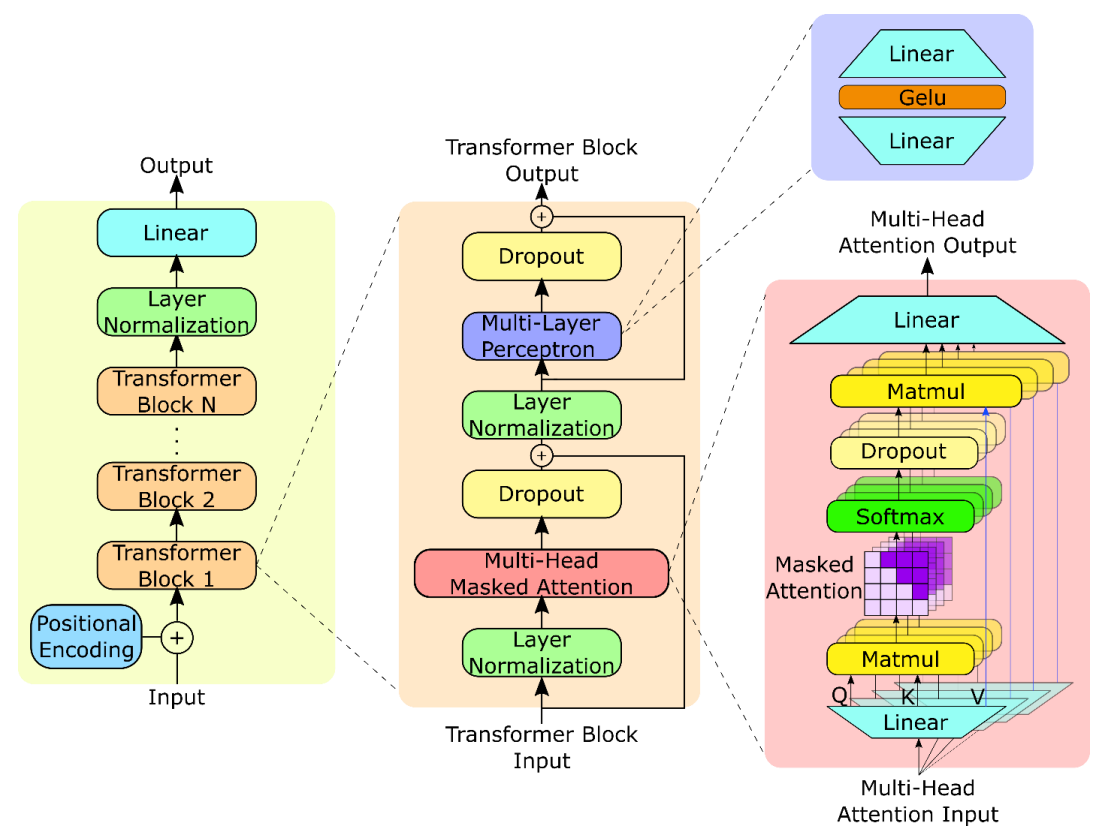


To use **multi-head attention** efficiently, we follow these steps:

* Let:

  * `nh` = number of heads (`self.n_head`)
  * `hs` = head size (`C // nh`), so `C = nh × hs`

### 🧠 Step-by-step process:

1. **Compute all queries, keys, and values (Q, K, V) for all Heads in a single linear layer**:

   ```python
   qkv = self.c_attn(x)  # shape: (B, T, 3 * C) , C = nh * hs
   ```

   This projects the input embeddings to Q, K, and V all at once, combining them into one tensor for efficiency.

2. **Split the QKV tensor into separate Q, K, and V**:

   ```python
   q, k, v = qkv.split(C, dim=2)  # each of shape: (B, T, C)
   ```

   Each of these still represents all heads together in a flat embedding space.

3. **Reshape to separate heads, and prepare for batched matrix multiplication**:

   ```python
   q = q.view(B, T, nh, hs).transpose(1, 2)  # shape: (B, T, C) > (B, T, nh, hs) > (B, nh, T, hs)
   ```

   This reshapes each tensor to expose the `nh` heads as a separate dimension and transposes it so the head dimension (`nh`) comes before the sequence dimension (`T`).

   Repeat for `k` and `v`.

4. **Why this shape matters**:
   With shape `(B, nh, T, hs)`, the attention computation internally treats the batch as having `B × nh` parallel sequences. This structure allows efficient batched matrix multiplications:

   * Each attention head independently computes dot products and attention scores.
   * Computation is effectively parallel over both batch size (`B`) and number of heads (`nh`).


This structure enables highly efficient and scalable attention mechanisms, especially when using optimized implementations like Flash Attention.




In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1,1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        qkv = self.c_attn(x) # shape: (B, T, 3 * C)
        q, k, v = qkv.split(self.n_embd, dim=2) # Each of shape (B, T, C)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1,2).contiguous().view(B, T, C) # (B, nh, T, hs) → (B, T, nh, hs) → (B, T, nh * hs) = (B, T, C)

        y = self.c_proj(y)

        return y


In [ ]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

The line:

```python
self.transformer["wte"].weight = self.lm_head.weight
```

**means that the input embedding weights and the output projection weights are shared.**

### Let's break this down:

* `self.transformer["wte"]` is the **word token embedding layer**: it maps token IDs to dense vectors of size `n_embd`.
* `self.lm_head` is the **final linear layer** used to project the transformer output back to vocabulary logits (for prediction).

In detail:

* The **embedding layer** (`nn.Embedding(config.vocab_size, config.n_embd)`) has weights of shape `(vocab_size, n_embd)`.
* The **output layer** (`nn.Linear(config.n_embd, config.vocab_size, bias=False)`) has weights of shape `(vocab_size, n_embd)` — *notice the same shape* (but in transposed order).

By doing:

```python
self.transformer["wte"].weight = self.lm_head.weight
```

you **force both layers to use the exact same weight tensor** (i.e., no duplication of memory). This is called **weight tying** or **weight sharing**.



---

### Weight Initialization in GPT

In transformer-based models like GPT, proper weight initialization is critical for stable training and efficient convergence. The `_init_weights` method in the `GPT` class ensures this by initializing weights according to module type and depth.

#### Initialization Strategy

The method applies the following rules based on the type of submodule (`nn.Module`):

1. **Linear Layers (`nn.Linear`)**:

   * Initialized with a normal distribution (`mean=0.0`) and standard deviation of **0.02** by default.
   * If the layer has the `NANOGPT_SCALE_INIT` flag (used in `MLP` and `CausalSelfAttention`), the standard deviation is adjusted as:

     $$
     \text{std} = \frac{0.02}{\sqrt{2 \times \text{n\_layer}}}
     $$

     This accounts for the two residual paths in each transformer block (attention and MLP).
   * Biases are initialized to zero.

2. **Embedding Layers (`nn.Embedding`)**:

   * Both token (`wte`) and position (`wpe`) embeddings are initialized with a normal distribution (std = **0.02**).

3. **Layer Normalization (`nn.LayerNorm`)**:

   * Not explicitly re-initialized since PyTorch’s default initialization (scale = 1, bias = 0) is sufficient.

---

### Why Use the Same Scale in All Layers for Linear Layers (`nn.Linear`)?

While it may seem intuitive to adjust the initialization scale based on a layer’s position — since deeper layers pass through fewer residual connections — GPT uses the **same scaled initialization for all layers**, based on the total number of blocks. Here's why:

* **Residual Connections Preserve Inputs**: Each block adds its output to its input, rather than replacing it, which maintains stable signal propagation.

---

### Why 0.02?

Although 0.02 might seem arbitrary, it aligns closely with the theoretical values of Xavier initialization for common hidden dimensions in GPT-style models:

| Hidden Dimension | 1 / √(Hidden Dimension) |
| ---------------- | ----------------------- |
| 768              | 0.036                   |
| 1024             | 0.031                   |
| 1280             | 0.028                   |
| 1600             | 0.025                   |

Thus, **0.02 is a conservative and practical default** that works well in combination with normalization and residual connections.




In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer["wte"].weight = self.lm_head.weight

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device).unsqueeze(0)  # shape (1, T)
        pos_emb = self.transformer["wpe"](pos)               # (1, T, n_embd)
        tok_emb = self.transformer["wte"](idx)               # (B, T, n_embd)
        x = tok_emb + pos_emb                                # broadcasting (B, T, n_embd)

        # forward the blocks of the transformer
        for block in self.transformer["h"]:
            x = block(x)

        # final layernorm and output projection
        x = self.transformer["ln_f"](x)
        logits = self.lm_head(x)                             # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens
    n_layer: int = 12 # number of transformer layers
    n_head: int = 12 # number of heads in multi-head attention
    n_embd: int = 768 # embedding dimension

# Simple test

In [ ]:
# Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-05-04 15:08:04--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-05-04 15:08:04 (24.9 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

with open('input.txt', 'r') as f:
    text = f.read()

text = text[:1000]
tokens = enc.encode(text)
print(f"There are {len(tokens)} tokens")

There are 285 tokens


In [ ]:
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
x = buf[:-1].view(B,T)
y = buf[1:].view(B,T)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT(GPTConfig())
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params}")

Total parameters: 124439808


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for i in range(10):
  optimizer.zero_grad()
  logits, loss = model(x.to(device),y.to(device))
  loss.backward()
  optimizer.step()
  print(f"step {i}, Loss : {loss.item()}")



step 0, Loss : 11.06688404083252
step 1, Loss : 7.3158698081970215
step 2, Loss : 5.650364398956299
step 3, Loss : 4.5834059715271
step 4, Loss : 4.469760417938232
step 5, Loss : 3.5176796913146973
step 6, Loss : 3.2235183715820312
step 7, Loss : 2.8106191158294678
step 8, Loss : 2.5459651947021484
step 9, Loss : 2.347970962524414


# New Section

In [ ]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open('input.txt', "r") as f:
            text = f.read()

        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # stat
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position+(B*T + 1)]
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B,T)

        self.current_position += B * T
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0
        return x,y

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

train_loader = DataLoaderLite(B=4, T=32)

model = GPT(GPTConfig())
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for i in range(10):
  optimizer.zero_grad()
  x, y = train_loader.next_batch()
  logits, loss = model(x.to(device),y.to(device))
  loss.backward()
  optimizer.step()
  print(f"step {i}, Loss : {loss.item()}")


Device: cpu
1 epoch = 2640 batches
step 0, Loss : 11.057626724243164
step 1, Loss : 9.81591510772705
step 2, Loss : 9.06009578704834
step 3, Loss : 9.207348823547363
step 4, Loss : 8.667938232421875
step 5, Loss : 8.373002052307129
step 6, Loss : 9.010164260864258
step 7, Loss : 8.875380516052246
step 8, Loss : 8.1599702835083
step 9, Loss : 8.004850387573242


# New Section

In [ ]:
import torch
import numpy as np
import tiktoken
from torch.nn.utils import clip_grad_norm_
import time
from tqdm import tqdm

# ==== Set Seed for Reproducibility ====
def set_seed(seed=1337):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ==== Random Batch Generator ====
class RandomBatchGenerator:
    def __init__(self, file_path='input.txt', block_size=128, batch_size=32,
                 device='cpu', split='train', split_ratio=0.9, encoding_name='gpt2'):
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device

        # Load and tokenize text
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Train/Val split
        split_idx = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_idx]
        elif split == 'val':
            self.tokens = self.tokens[split_idx:]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.max_start = len(self.tokens) - block_size - 1
        if self.max_start <= 0:
            raise ValueError("block_size too large for the dataset.")

    def next_batch(self):
        #idx = torch.randint(0, self.max_start, (self.batch_size,))
        idx = torch.randint(0, self.max_start // self.block_size, (self.batch_size,)) * self.block_size
        idx = idx.unsqueeze(1) + torch.arange(self.block_size).unsqueeze(0)
        x = self.tokens[idx]
        y = self.tokens[idx + 1]
        return x.to(self.device), y.to(self.device)

Example

```
idx = torch.randint(0, 1000, (3,))  # Example: [210, 784, 567]

offsets = torch.arange(5).unsqueeze(0)  # shape (1, 5): [[0, 1, 2, 3, 4]]

idx = idx.unsqueeze(1) + offsets  # shape (3, 5)
idx = [[210, 211, 212, 213, 214],
       [784, 785, 786, 787, 788],
       [567, 568, 569, 570, 571]]
```



In [ ]:
# ==== Evaluation Function ====
def evaluate_loss(model, dataloader, device, max_batches=10):
    model.eval()
    total_loss, count = 0.0, 0

    with torch.no_grad():
        for _ in range(max_batches):
            x, y = dataloader.next_batch()
            _, loss = model(x.to(device), y.to(device))
            total_loss += loss.item()
            count += 1

    model.train()
    return total_loss / count if count > 0 else float('inf')

In [ ]:
torch.set_float32_matmul_precision('highest')

# ==== Training Configuration ====
class Config:
    max_iter = 100
    log_interval = 10
    grad_clip = 1.0
    lr = 3e-4
    block_size = 1024
    batch_size = 4
    seed = 1337
    file_path = 'input.txt'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ==== Initialize ====
print(f"Using device: {Config.device}")
print(f"Current precision: {torch.get_float32_matmul_precision()}")
set_seed(Config.seed)

train_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                   batch_size=Config.batch_size, split='train', device=Config.device)
val_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                 batch_size=Config.batch_size, split='val', device=Config.device)

# ==== Model and Optimizer ====
model = GPT(GPTConfig()).to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)

# ==== Training Loop ====
running_loss = 0.0
start_time = time.time()

for step in tqdm(range(1, Config.max_iter + 1), desc="Training"):
    x, y = train_data.next_batch()
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), Config.grad_clip)
    optimizer.step()

    running_loss += loss.item()

    if step % Config.log_interval == 0:
        avg_train_loss = running_loss / Config.log_interval
        val_loss = evaluate_loss(model, val_data, Config.device)
        torch.cuda.synchronize()
        elapsed = time.time() - start_time
        tokens_per_sec = (Config.batch_size * Config.block_size) / elapsed

        print(f"Step {step:4d} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Token/sec : {tokens_per_sec:.2f}")

        running_loss = 0.0
        start_time = time.time()


Using device: cuda
Current precision: highest


Training:  10%|█         | 10/100 [00:15<03:27,  2.31s/it]

Step   10 | Train Loss: 8.7445 | Val Loss: 7.3855 | Token/sec : 270.04


Training:  20%|██        | 20/100 [00:30<03:06,  2.34s/it]

Step   20 | Train Loss: 6.8369 | Val Loss: 6.6221 | Token/sec : 264.68


Training:  30%|███       | 30/100 [00:45<02:38,  2.26s/it]

Step   30 | Train Loss: 6.5212 | Val Loss: 6.6128 | Token/sec : 271.77


Training:  40%|████      | 40/100 [01:00<02:13,  2.23s/it]

Step   40 | Train Loss: 6.4504 | Val Loss: 6.6595 | Token/sec : 276.46


Training:  44%|████▍     | 44/100 [01:06<01:24,  1.50s/it]


KeyboardInterrupt: 

# Float precision

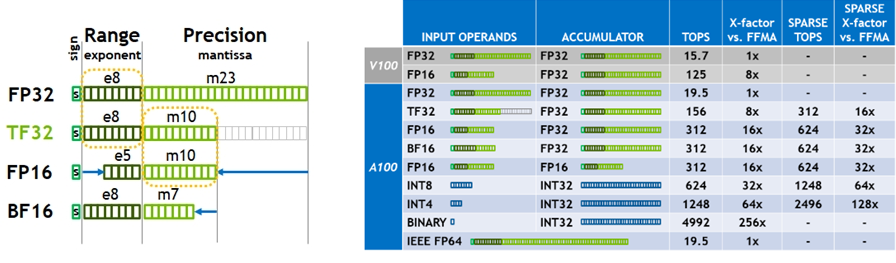


### ✅ Which Precision Setting Should You Use for Float32 Matrix Multiplications?

PyTorch allows you to control the precision of float32 matrix multiplications using:

```python
torch.set_float32_matmul_precision('high')
```

This affects performance and accuracy trade-offs **only on compatible GPUs** (Ampere or newer).

#### 🔹 `'high'` (Recommended Default)

* Enables TF32 acceleration (TensorFloat-32) for many float32 matmul operations.
* Balances speed and accuracy well.
* Suitable for most training workloads.

#### 🔹 `'highest'` (Full Float32 Precision)

* Disables TF32 usage.
* Uses standard IEEE float32 math for all matrix multiplications.
* Recommended only if you need maximum numerical precision (e.g., sensitive scientific computing or gradient reproducibility).

#### 🔹 `'medium'` (Maximum Speed)

* Prioritizes performance over accuracy by allowing more aggressive use of TF32.
* Best for inference, early experimentation, or when minor precision loss is acceptable.

---

### ⚠️ Important Caveat for Google Colab Users

In Google Colab, you typically get **older GPUs** such as:

* **Tesla T4 (Volta architecture)** or older (P100, K80)
* These **do not support TF32**, which means:

  * `torch.set_float32_matmul_precision(...)` **has no effect**
  * No speed or precision trade-off will be observed

You can check your GPU type by running:

```bash
!nvidia-smi
```

If it shows `Tesla T4` or older, TF32 is not supported, and the precision setting won't make any difference.




In [ ]:
!nvidia-smi

Sat May  3 21:27:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             31W /   70W |   10504MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.set_float32_matmul_precision('high')

# ==== Training Configuration ====
class Config:
    max_iter = 100
    log_interval = 10
    grad_clip = 1.0
    lr = 3e-4
    block_size = 1024
    batch_size = 4
    seed = 1337
    file_path = 'input.txt'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ==== Initialize ====
print(f"Using device: {Config.device}")
print(f"Current precision: {torch.get_float32_matmul_precision()}")
set_seed(Config.seed)

train_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                   batch_size=Config.batch_size, split='train', device=Config.device)
val_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                 batch_size=Config.batch_size, split='val', device=Config.device)

# ==== Model and Optimizer ====
model = GPT(GPTConfig()).to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)

# ==== Training Loop ====
running_loss = 0.0
start_time = time.time()

for step in tqdm(range(1, Config.max_iter + 1), desc="Training"):
    x, y = train_data.next_batch()
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), Config.grad_clip)
    optimizer.step()

    running_loss += loss.item()

    if step % Config.log_interval == 0:
        avg_train_loss = running_loss / Config.log_interval
        val_loss = evaluate_loss(model, val_data, Config.device)
        torch.cuda.synchronize()
        elapsed = time.time() - start_time
        tokens_per_sec = (Config.batch_size * Config.block_size) / elapsed

        print(f"Step {step:4d} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Token/sec : {tokens_per_sec:.2f}")

        running_loss = 0.0
        start_time = time.time()

# Autocast

### 🔍 What Is `torch.autocast(...)`?

`torch.autocast` is a context manager that **automatically casts** certain operations (e.g., matrix multiplications, convolutions) to a **lower-precision format** — here, `bfloat16` — to improve speed and reduce memory usage **while maintaining acceptable model accuracy**.

---

### 📌 What This Line Does:

```python
with torch.autocast(device_type=device, dtype=torch.bfloat16):
    logits, loss = model(x, y)
```

means:

* Inside this block, PyTorch will **dynamically use bfloat16** precision (instead of default float32) for operations that benefit from it (like linear layers, matmuls).
* Other operations (e.g., indexing, non-mathematical ops) will still run in float32 to **preserve stability**.
* This happens **only if your GPU supports `bfloat16`** (e.g., A100, H100, RTX 40xx, some Ampere GPUs with newer drivers).

---

### 🧠 Why Use `bfloat16` Instead of `float16`?

* `bfloat16` (Brain Float 16) has the **same exponent range as float32** but fewer bits for the mantissa.
* This makes it **more stable numerically** than `float16`, especially during training.
* Many modern NVIDIA GPUs (e.g., your RTX A2000) **support bfloat16** in recent CUDA versions.

---

### ⚠️ Requirements & Considerations

* ✅ Works best on Ampere or newer GPUs
* ✅ Requires PyTorch >= 1.10
* ✅ For training, this should typically be combined with a **gradient scaler** (e.g., `torch.cuda.amp.GradScaler`) for stability — though your code omits this, it *can still work* if gradients don’t underflow
* ⚠️ Has no effect on CPUs or unsupported GPUs

---

### ✅ Summary

| Feature               | Effect                                                            |
| --------------------- | ----------------------------------------------------------------- |
| `torch.autocast(...)` | Automatically runs some ops in lower precision (`bfloat16`)       |
| `dtype=bfloat16`      | Use `bfloat16` instead of `float16` (better stability)            |
| Benefit               | Faster training, reduced memory use, often no loss in accuracy    |
| Safe?                 | Yes — autocast keeps critical ops in float32 to avoid instability |




# PyTorch Compile

### 🔍 What `torch.compile()` Does:

`torch.compile()` wraps your PyTorch model and uses the **TorchDynamo**, **AOTAutograd**, and **Inductor** components to:

* **Capture** and trace the model's forward and backward passes.
* **Optimize** them using graph-level transformations.
* **Generate faster low-level code** (often via LLVM or Triton).
* Potentially **improve performance** on both CPUs and GPUs, especially for large models or long sequences.

---

### ⚙️ In Your Code Context:

```python
model = GPT(GPTConfig()).to(Config.device)
model = torch.compile(model)
```

This means:

* You first initialize the model and move it to the appropriate device (`CPU` or `CUDA`).
* Then you compile it. From that point on, calls to `model(x, y)` will be optimized.

---

### ✅ Benefits of Using `torch.compile()`:

* **Speed**: Can lead to **2x or more** performance improvements for some models.
* **Seamless Integration**: You don’t need to change how you write training loops or model code.
* **Device-aware**: Works on both GPU and CPU (with more performance gains typically on GPU).



# FlashAttention


```python
# Old (manual)
att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
att = F.softmax(att, dim=-1)
y = att @ v

# New (optimized)
y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
```


This **replaces all** of the above lines **with a single, optimized call**. If you're using a recent PyTorch (>= 2.0) with a compatible GPU (like A100 or RTX 30/40 series), this will trigger **Flash Attention v2** under the hood.

---

### ⚡ What is Flash Attention?

Flash Attention is a **memory-efficient, faster algorithm** for computing attention. Developed by Tri Dao et al., it:

* **Reduces memory overhead** by computing attention in **chunks** and **avoiding full materialization** of large intermediate tensors.
* **Fuses** operations like softmax and dropout into a **single kernel** for speed.
* Can process **very long sequences** (e.g., 8K+ tokens) that would otherwise run out of memory.

---

### 🔍 Under the Hood

Instead of computing `attn = softmax(QKᵀ / √d)` all at once, Flash Attention:

* Computes it **block-by-block**, storing only what's needed.
* Performs **fused operations** in CUDA kernels.
* Applies **causal masking** internally when `is_causal=True`.

---

### 🧠 Why It Matters

| Feature                | Manual Attention      | `F.scaled_dot_product_attention` (with Flash) |
| ---------------------- | --------------------- | --------------------------------------------- |
| Memory usage           | High                  | Much lower (streamed computation)             |
| Speed                  | Moderate              | Up to 2–4x faster                             |
| Max sequence length    | Limited by memory     | Can scale to 8K+ tokens                       |
| Readability            | Verbose               | One-liner                                     |
| Autoregressive support | Manual masking needed | Built-in with `is_causal=True`                |


Same output, **much better performance**.



# Increasing Vocabulary Size


In GPT-2, the original vocab size is **50257**, which includes special tokens used by the `tiktoken` BPE tokenizer.

---

### ⚠️ The Problem with 50257

While 50257 is fine from a model perspective, it **doesn’t align well with GPU hardware**, particularly:

1. **Non-power-of-2 size**: 50257 is not close to any power of 2 or common alignment size (like 512, 1024, or 64-multiples).
2. **Inefficient memory access**: GPUs prefer memory to be laid out in **aligned blocks** for faster loads and stores.
3. **Inefficient kernel launches**: GPU compute kernels (e.g., for matrix multiplications or softmax ops) often work best when tensor shapes are divisible by 16, 32, or 64 due to **warp sizes** and **SIMD constraints**.

So using 50257 often results in:

* **Padding internally** to the next multiple (wasting memory).
* **Fragmented memory access**, which leads to under-utilized GPU cores.
* **Unaligned computation** during large matrix operations (like logits computation or backprop).

---

### ✅ Why 50304 Improves Things

**50304 = 64 × 786**, a number that **aligns cleanly with common GPU-friendly dimensions** like:

* **64**: a multiple of **NVIDIA warp size (32)** and common vectorized data layouts.
* Close to **power-of-2** dimensions for efficient block scheduling.

By increasing the vocabulary size to **50304**, you:

1. ✅ **Enable better Tensor Core utilization** (especially on NVIDIA GPUs like A100s and 3090s).
2. ✅ **Reduce internal padding waste** — the model now aligns naturally with the GPU’s expected block sizes.
3. ✅ **Improve memory coalescing** — GPU threads can access contiguous memory chunks more efficiently.
4. ✅ **Reduce kernel launch inefficiency** — no more weird leftovers due to prime-number vocab size.

---

### 🔍 Real Impact in Training

In practice:

* You might see **5–15% faster training** on large models.
* More stable performance when training with **mixed precision (bfloat16 or float16)**.
* Lower GPU memory fragmentation (especially important for long context sizes).

**Important note**: You're not adding new *tokens* (semantics remain the same); you're just increasing the size of the **output dimension** to align with hardware preferences.

---

### 🏗️ How This Works in Code

In your model definition:

```python
vocab_size = 50304  # instead of 50257
```

And tokenizer stays the same (still outputs token IDs ≤ 50256); the extra unused tokens are just **padding space**.

---

## ✅ Summary

| Concept                     | 50257            | 50304 (Improved)       |
| --------------------------- | ---------------- | ---------------------- |
| Aligned to GPU kernel sizes | ❌ No             | ✅ Yes (multiple of 64) |
| Memory access efficiency    | ❌ Suboptimal     | ✅ Better coalescing    |
| Tensor Core usage           | ❌ Underutilized  | ✅ Fully used           |
| Logits/Softmax efficiency   | ❌ Fragmented ops | ✅ Vectorized ops       |
| Training speed              | Slower           | Faster (5–15%)         |
| Effect on model output      | Same             | Same                   |



# Hyperparameters

Up until this point we have been following the approach used in GPT-2. GPT-3 is very similar to GPT-2 except it is trained for much longer and with a larger context window. GPT-3 was also trained with slightly more optimised parameters. Thus we can add some of these optimisations into our model.

## Adam optimiser

In the GPT-3 paper, all model variants are trained using the **Adam optimizer** with the following hyperparameters:

* **β₁ = 0.9**
* **β₂ = 0.95**
* **ε = 1e-8**

This setup differs slightly from the typical default of β₂ = 0.999. Lowering β₂ helps **reduce the optimizer's memory of past gradients**, which can improve convergence stability in large-scale training.

In PyTorch, this configuration can be implemented using `AdamW`, which decouples weight decay from the gradient update:

```python
torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
```

This optimizer setup is effective for training large language models and aligns with the choices made in GPT-3's large-scale experiments.


## Gradient Clipping

> ✂️**Why clip gradients?**

In deep transformer models like GPT-3, especially during early training or when using large learning rates, gradients can occasionally explode (i.e., become excessively large). This can destabilize training, leading to:

* NaNs or Infs in weights or loss.
* Diverging training curves.
* Unpredictable learning behavior.

To mitigate this, GPT-3 **clips the global norm of the gradients at 1.0**, ensuring that:

* The update direction is preserved, but the step size is controlled.
* Large gradient spikes (outliers) are tamed.
* Training remains numerically stable, even in the presence of sharp loss surfaces.

This is crucial for **large models** with high-dimensional parameter spaces.

---

> ✅ **Code Example (PyTorch)**

```python
# Clip the global norm of all gradients to 1.0
grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

* `clip_grad_norm_` scales all gradients proportionally if their global norm exceeds `1.0`.
* Returns the total norm **before** clipping, which you can log for debugging or monitoring.

---
> 🧠 **Why `1.0` specifically?**

The GPT-3 paper doesn't justify `1.0` explicitly, but this threshold is a **widely accepted default** that balances:

* Avoiding overly small updates (if too strict, e.g., `0.1`).
* Preventing gradient explosions (if too high, e.g., `10.0`).

In practice, you can treat this as a tunable hyperparameter — but `1.0` is a solid, battle-tested baseline for transformer models.


## Learning Rate Schedule


>📉 **Learning Rate Schedule in GPT-3: Warmup + Cosine Decay**

Instead of using a constant learning rate, **GPT-3** adopts a **learning rate schedule** that helps stabilize training and improve convergence. The schedule has two main phases:

1. **Linear Warmup**:
   Gradually increase the learning rate from 0 to the maximum (`max_lr`) over the first `warmup_steps` iterations. This avoids sudden large updates that can destabilize early training.

2. **Cosine Decay**:
   After the warmup phase, the learning rate gradually decays to a minimum value (`min_lr`, typically 10% of `max_lr`) using a cosine curve. This allows finer updates as training progresses.

---

> 🔧 **Custom Implementation**

```python
import math

# Learning rate schedule parameters
MAX_LR = 6e-4
MIN_LR = MAX_LR * 0.1
WARMUP_STEPS = 10
max_steps = 1000

def get_lr(step: int) -> float:
    """
    Compute the learning rate at a given training step using:
    1. Linear warmup for the first WARMUP_STEPS
    2. Cosine decay from MAX_LR to MIN_LR until max_steps
    """
    if step < max_steps:
        # Linear warmup
        return MAX_LR * (step + 1) / WARMUP_STEPS

    if step >= TOTAL_STEPS:
        # Learning rate floor
        return MIN_LR

    # Cosine decay
    decay_ratio = (step - WARMUP_STEPS) / (max_steps - WARMUP_STEPS)
    decay_ratio = min(max(decay_ratio, 0.0), 1.0)  # Clamp between [0, 1]
    cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_ratio))
    lr = MIN_LR + (MAX_LR - MIN_LR) * cosine_decay
    return lr
```

> 🔄 **How It’s Applied in Training**


> `for param_group in optimizer.param_groups:`

* `optimizer.param_groups` is a list of dictionaries that hold different hyperparameters (like learning rate) for parameter groups.
* Even if you have one group (standard case), it's still a list.


> `param_group["lr"] = lr`

* This updates the learning rate **in-place** for the optimizer at this step.
* This is how you make the optimizer use a different learning rate **without reinitializing it**.

```python
for step in range(max_steps):
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
```

---

> 📊 **Learning Rate Curve Visualization**

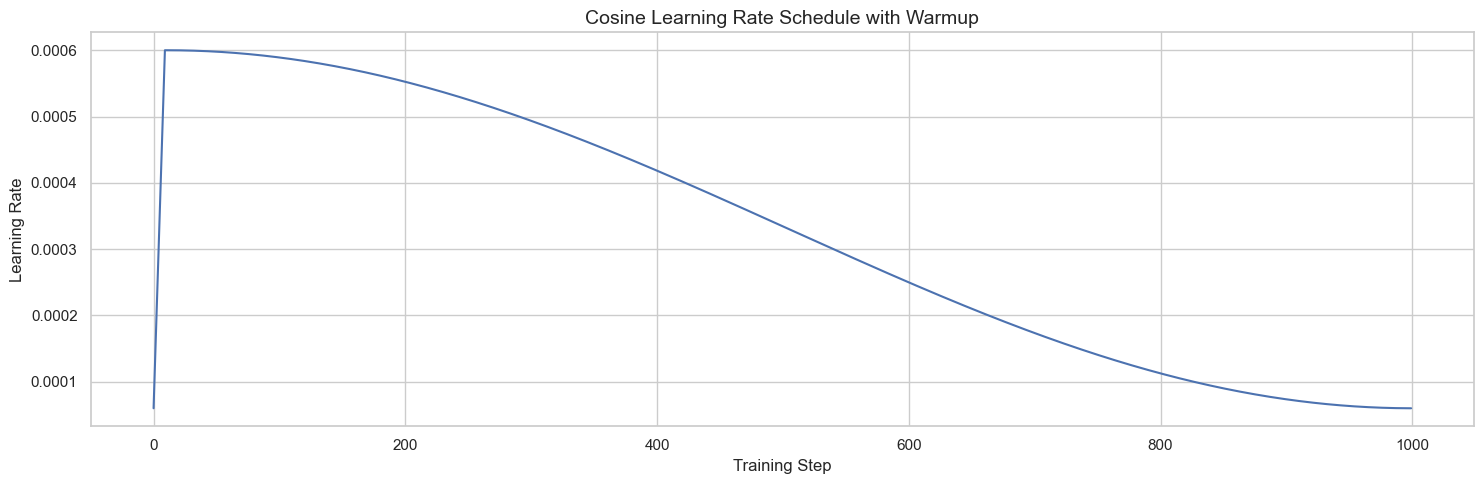


## Batch Size Scheduling

GPT-3 employs **batch size scheduling**, gradually increasing the effective batch size over the course of training. Specifically, it ramps up from **32k tokens** to the **full batch size** between the first **4 to 12 billion tokens**, depending on the model size.

While this strategy offers only **marginal gains** in model quality, it is primarily a **systems-level optimization** — aiming to improve **training stability** and **efficiency**, rather than providing algorithmic breakthroughs.

> 🧠 **Intuition**

The early stages of training are dominated by **large, obvious gradient updates**(simple patterns), often corresponding to low-hanging patterns (e.g., very rare or trivial tokens). Smaller batch sizes allow the model to converge more quickly during this phase. As training progresses and gradients become smaller and more nuanced, increasing the batch size improves computational efficiency without harming convergence.

> 📝 **Note on Data Sampling**

During data loading and batching, **sampling is done without replacement within each epoch**. This helps reduce overfitting by ensuring that every token is seen only once per epoch, preventing the model from memorizing patterns prematurely.

> 🚫 **Skipped in our approach**

For simplicity, we skip implementing batch size scheduling in our approach. However, it’s a valuable technique to be aware of when training large-scale models at scale.


In [ ]:
def configure_optimizers(self, weight_decay, learning_rate, device_type):
    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in self.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    print(f"using fused AdamW: {use_fused}")
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
    return optimizer

## Weight Decay

> 📌 **Why Use Weight Decay?**

Weight decay is a regularization technique used to **prevent overfitting** by discouraging large weights in the model. It works by **penalizing the magnitude of parameters**, effectively shrinking them during training. This helps the model generalize better to unseen data, especially in large architectures like transformers.

Mathematically, it modifies the update rule by adding a term proportional to the weights themselves:

```
w ← w - lr * (∇L(w) + λ * w)
```

Where `λ` is the weight decay coefficient (e.g., `0.1`).


> ⚙️ **Why Separate Parameters?**

Not all parameters in a model should be regularized equally:

* **Weights** (like in linear and attention layers) benefit from weight decay.
* **Biases** and **LayerNorm parameters** typically **should not** be regularized.

To account for this, we **manually separate** parameters into two groups:

* `decay_params`: tensors with 2 or more dimensions (e.g., weights in linear layers).
* `nodecay_params`: 1D tensors or scalars (e.g., biases, layer norm weights).

This separation allows for **fine-grained control** over which parameters get weight decay and which do not — a best practice when training deep networks.

> ⚡ **Why Use Fused AdamW?**

PyTorch offers a **fused** variant of the `AdamW` optimizer, which uses **kernel fusion** to improve efficiency on CUDA-enabled devices. Instead of launching many small GPU kernels (e.g., one per parameter), it fuses the update logic into **fewer, larger kernels**, reducing overhead and improving memory throughput.

Using `fused=True` can significantly accelerate training, especially for large models on modern GPUs.

---

> 🔧 **Optimizer Configuration Method**

```python
def configure_optimizers(self, weight_decay, learning_rate, device_type):
    import inspect

    # Select parameters that require gradients
    param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

    # Separate parameters for weight decay
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]

    # Display parameter distribution
    print(f"decay param tensors: {len(decay_params)}, total: {sum(p.numel() for p in decay_params):,}")
    print(f"no-decay param tensors: {len(nodecay_params)}, total: {sum(p.numel() for p in nodecay_params):,}")

    # Use fused AdamW if supported and on CUDA
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    print(f"Using fused AdamW: {use_fused}")

    optimizer = torch.optim.AdamW(
        optim_groups,
        lr=learning_rate,
        betas=(0.9, 0.95),
        eps=1e-8,
        fused=use_fused
    )
    return optimizer
```

> 🚀 **How to Use in Your Training Script**

Before starting training, configure your optimizer like this:

```python
optimizer = model.configure_optimizers(
    weight_decay=0.1,
    learning_rate=max_lr,
    device_type=device
)
```




# Bckground


### 🔍 What is `.contiguous()`?

In PyTorch, **tensors are views of memory**. When you do operations like `.transpose()` or `.permute()`, PyTorch often creates a **new view** of the same data in memory — it doesn’t move the actual data, just changes how it is accessed. As a result, the tensor **might not be stored in a contiguous block of memory** anymore.

This matters because some operations — like `.view()` — **require** the tensor to be contiguous in memory. If it's not, `.view()` can't guarantee the data will be laid out correctly, and will raise an error or produce incorrect results.

---

### 🧠 Example:

```python
x = torch.randn(2, 3, 4)
x_t = x.transpose(1, 2)  # shape is now (2, 4, 3), but memory is not contiguous

x_t.view(2, 12)  # ⚠️ Error! because x_t is not contiguous
x_t.contiguous().view(2, 12)  # ✅ Now works: makes a copy with contiguous memory
```

---

### 📌 In your code:

```python
y = y.transpose(1, 2).contiguous().view(B, T, C)
```

* `y` originally is shape `(B, nh, T, hs)`
* `transpose(1, 2)` → shape `(B, T, nh, hs)`, but **not contiguous**
* `.contiguous()` makes it memory-safe
* `.view(B, T, C)` collapses `nh * hs → C`

So `.contiguous()` ensures the `.view()` works correctly by **reordering the data** in memory so that the new shape makes sense.

---

### ⚠️ Without `.contiguous()`

If you try to call `.view()` on a non-contiguous tensor, PyTorch might raise an error or silently give wrong results — depending on the situation.


### ✅ What does `@dataclass` do?

When you write:

```python
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
```

Python automatically generates useful methods for the class:

* `__init__()`
* `__repr__()`
* `__eq__()`
* and others...

So instead of writing this manually:

```python
class GPTConfig:
    def __init__(self, block_size=1024, vocab_size=50257, ...):
        self.block_size = block_size
        self.vocab_size = vocab_size
        ...
```

You just use `@dataclass` and list the attributes, and Python handles the rest.

---

### 🔧 Usage:

```python
config = GPTConfig()
print(config.n_layer)  # 12
print(config)  # GPTConfig(block_size=1024, vocab_size=50257, ...)
```

You can also override any default:

```python
custom_config = GPTConfig(n_layer=24)
```

---

### 📌 Summary:

`@dataclass` makes `GPTConfig` a clean, concise, and efficient way to manage configuration options, especially for deep learning models where many hyperparameters are grouped together.


### New Section

In [ ]:
import torch
from torch.utils.data import Dataset
import tiktoken

class TextDataset(Dataset):
    def __init__(self, file_path='input.txt', block_size=128,
                 device='cpu', split='train', split_ratio=0.9,
                 encoding_name='gpt2'):
        self.block_size = block_size
        self.device = device

        # Load and tokenize text
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Train/validation split
        split_index = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_index]
        elif split == 'val':
            self.tokens = self.tokens[split_index:]
        else:
            raise ValueError("split must be either 'train' or 'val'")

        self.num_samples = len(self.tokens) - block_size
        #print(len(self.tokens) - block_size)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = self.tokens[idx:idx + self.block_size].to(self.device)
        y = self.tokens[idx + 1:idx + self.block_size + 1].to(self.device)
        return x, y



In [ ]:
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

B, T = 128, 32

train_dataset = TextDataset(file_path='input.txt', block_size=B, device=device, split='train', split_ratio=0.9)
val_dataset   = TextDataset(file_path='input.txt', block_size=B, device=device, split='val')

train_loader = DataLoader(train_dataset, batch_size=T, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=T)



Device: cuda


In [ ]:
def evaluate_loss(model, dataloader, device, max_batches=None):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for i in range(max_batches):
            x, y = dataloader.next_batch()
            logits, loss = model(x.to(device), y.to(device))
            total_loss += loss.item()
            count += 1

    model.train()  # back to training mode
    return total_loss / count if count > 0 else float('inf')

In [ ]:
import torch
import tiktoken
import numpy as np

def set_seed(seed=1337):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class RandomBatchGenerator:
    def __init__(self, file_path='input.txt', block_size=128, batch_size=32,
                 device='cpu', split='train', split_ratio=0.9, encoding_name='gpt2'):
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device

        # Load and tokenize text
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Split into train/val
        split_idx = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_idx]
        elif split == 'val':
            self.tokens = self.tokens[split_idx:]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.max_start = len(self.tokens) - block_size - 1
        if self.max_start <= 0:
            raise ValueError("block_size too large for the dataset.")

    def next_batch(self):
        # Random start indices for each sample
        idx = torch.randint(0, self.max_start, (self.batch_size,))
        # Create (B, T) indices via broadcasting
        offsets = torch.arange(self.block_size).unsqueeze(0)  # shape (1, block_size)
        idx = idx.unsqueeze(1) + offsets  # shape (B, block_size)

        x = self.tokens[idx]
        y = self.tokens[idx + 1]
        return x.to(self.device), y.to(self.device)


Example

```
idx = torch.randint(0, 1000, (3,))  # Example: [210, 784, 567]

offsets = torch.arange(5).unsqueeze(0)  # shape (1, 5): [[0, 1, 2, 3, 4]]

idx = idx.unsqueeze(1) + offsets  # shape (3, 5)
idx = [[210, 211, 212, 213, 214],
       [784, 785, 786, 787, 788],
       [567, 568, 569, 570, 571]]
```



In [ ]:
import time

max_iter = 1000
log_interval = 100
grad_clip = 1.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

B, T = 128, 32


set_seed(1337)
train_data = RandomBatchGenerator(file_path='input.txt', block_size=T, batch_size=B, split='train', device=device)
val_data = RandomBatchGenerator(file_path='input.txt', block_size=T, batch_size=B, split='val', device=device)


# Initialize model and optimizer
model = GPT(GPTConfig()).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

running_train_loss = 0.0
model.train()

start_time = time.time()

for step in range(max_iter):
    x, y = train_data.next_batch()
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    running_train_loss += loss.item()

    if step % log_interval == 0 and step > 0:
        avg_train_loss = running_train_loss / log_interval
        val_loss = evaluate_loss(model, val_data, device, max_batches=20)

        end_time = time.time()
        elapsed = end_time - start_time

        print(f"[Epoch {epoch+1}] Step {step} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss (est.): {val_loss:.4f} | "
              f"Time: {elapsed:.2f}s")

        running_train_loss = 0.0
        start_time = time.time()  # reset for next interval
